<a href="https://colab.research.google.com/github/gopzgopez/ece_151/blob/master/Denoising_Autoencoder_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow-gpu==1.14

In [0]:
import tensorflow as tf
print(tf.__version__)

In [0]:
! git clone https://github.com/baudm/ee298z.git

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from ee298z.hw2.transforms import corrupt_mnist_copy
from ee298z.hw2.benchmark_keras import test_model

In [0]:
(x_train, y_train), (x_bench, y_bench) = mnist.load_data()
x_test = x_bench
x_train_corrupted = corrupt_mnist_copy(x_train)
x_test_corrupted = corrupt_mnist_copy(x_test)

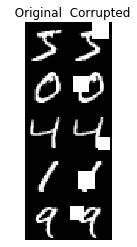

In [4]:
imgs = np.hstack([np.reshape(x_train[0:5],[140,28]), np.reshape(x_train_corrupted[0:5],[140,28])])
plt.figure()
plt.axis('off')
plt.title('  Original  Corrupted')
plt.imshow(imgs, interpolation='none', cmap='gray')

In [0]:
x_train = np.reshape(x_train, [60000, 28, 28, 1])
x_test = np.reshape(x_test, [10000, 28, 28, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train_corrupted = np.reshape(x_train_corrupted, [60000, 28, 28, 1])
x_test_corrupted = np.reshape(x_test_corrupted, [10000, 28, 28, 1])
x_train_corrupted = x_train_corrupted.astype(K.floatx()) / 255
x_test_corrupted = x_test_corrupted.astype(K.floatx()) / 255

In [6]:
print(x_train.shape)
print(x_test.shape)
print(x_train_corrupted.shape)
print(x_test_corrupted.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [7]:
input_shape = (28, 28, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
layer_filters = [32, 64]

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

shape = K.int_shape(x)
    
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [8]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)
    
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

In [9]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()
autoencoder.compile(loss='mse', optimizer='adam')

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________



In [10]:
history = autoencoder.fit(x_train_corrupted,
                          x_train,
                          validation_data=(x_test_corrupted, x_test),
                          epochs=15,
                          batch_size=batch_size)


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 26s 438us/step - loss: 0.0355 - val_loss: 0.0219
Epoch 2/15
60000/60000 [==============================] - 24s 398us/step - loss: 0.0206 - val_loss: 0.0192
Epoch 3/15
60000/60000 [==============================] - 24s 397us/step - loss: 0.0186 - val_loss: 0.0181
Epoch 4/15
60000/60000 [==============================] - 24s 396us/step - loss: 0.0176 - val_loss: 0.0174
Epoch 5/15
60000/60000 [==============================] - 25s 413us/step - loss: 0.0170 - val_loss: 0.0170
Epoch 6/15
60000/60000 [==============================] - 24s 407us/step - loss: 0.0165 - val_loss: 0.0168
Epoch 7/15
60000/60000 [==============================] - 24s 400us/step - loss: 0.0162 - val_loss: 0.0164
Epoch 8/15
60000/60000 [==============================] - 24s 398us/step - loss: 0.0159 - val_loss: 0.0162
Epoch 9/15
60000/60000 [==============================] - 24s 397us/step - loss: 0.0156 - val

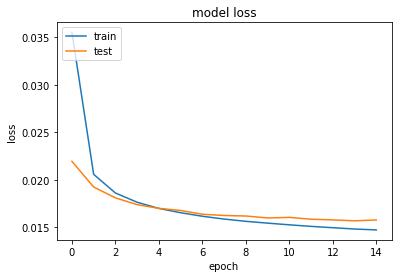

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
x_bench = x_bench.astype(K.floatx()) / 255.
test_model(autoencoder, x_bench, y_bench, batch_size=100)

Classifier score: 94.17
SSIM score: 90.16


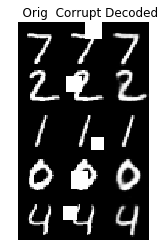

In [13]:
x_decoded = autoencoder.predict(x_test_corrupted)
imgs = np.hstack([np.reshape(x_test[0:5],[140,28]), np.reshape(x_test_corrupted[0:5],[140,28]), np.reshape(x_decoded[0:5],[140,28])])
plt.figure()
plt.axis('off')
plt.title('    Orig '
          ' Corrupt '
          'Decoded')
plt.imshow(imgs, interpolation='none', cmap='gray')